# CS 4342 Term Project
Veronica Gurnawan, Lucas Varella and Rakesh Veetekat


In [1]:
import pandas as pd 
import numpy as np
import matplotlib as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

training = pd.read_csv("train.csv")
testing = pd.read_csv("test.csv")


In [2]:
print('------Data Analysis------')
#We're trying to learn more about the data to get a general picture of what to look for. 

#Gender vs. Survived 
print(training[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean().sort_values(by="Survived", ascending=False))

#Observation from data: 74% of total women survived. 

------Data Analysis------
      Sex  Survived
0  female  0.742038
1    male  0.188908


In [3]:
#Class vs. Survived
print(training[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean().sort_values(by="Survived", ascending=False))

#Observation from data: 1st class > 2nd class > 3rd class survival 

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [4]:
#Sibling/Spouse vs. Survived
print(training[["SibSp", "Survived"]].groupby(["SibSp"], as_index=False).mean().sort_values(by="Survived", ascending=False))


   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


In [5]:
#Parent/Child vs. Survived
print(training[["Parch", "Survived"]].groupby(["Parch"], as_index=False).mean().sort_values(by="Survived", ascending=False))


   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


In [6]:
training['Age'].describe()
#Notice there are 714 values as opposed to 814 total passengers. 
#This accounts for 100 missing values. 



count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

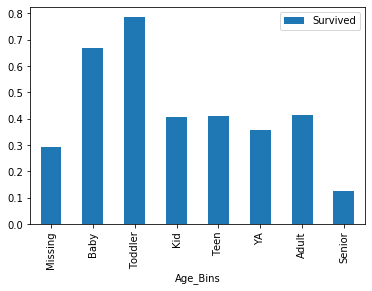

In [7]:
#We want to discretize the age column. 
def discretize(df, bounds, label_list):
    df['Age'] = df['Age'].fillna(-0.5)
    df['Age_Bins'] = pd.cut(df['Age'], bounds, labels=label_list)
    return df

bounds = [-1, 0, 3, 5, 13, 18, 30, 65, 105]
label_list = ["Missing", "Baby", "Toddler", "Kid", "Teen", "YA", "Adult", "Senior"]

training = discretize(training, bounds, label_list)
testing = discretize(testing, bounds, label_list)

#Visualization of the amount of people in each age demographic 
age_chart = training.pivot_table(index="Age_Bins", values="Survived")
age_chart.plot.bar()


In [8]:
#Vis 
training['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [9]:
#Further breaks down our data into a format usable with binary classification. 
#We want to itemize by column. 

#Applying this to all of the columns with potential features
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Age_Bins']
train = pd.get_dummies(training[features])
test = pd.get_dummies(testing[features])

#Splitting into training set and validation set 
X_train, X_test, y_train, y_test = train_test_split(training, training.Survived, test_size=0.2)


In [10]:
print('------Random Forest Classifier------')
print('Running on validation set')

Vtrain = pd.get_dummies(X_train[features])
Vtest = pd.get_dummies(X_test[features])

rfc_modelV = RandomForestClassifier(n_estimators=100,
                                   max_depth=5,
                                   random_state=1)
rfc_modelV.fit(Vtrain, y_train)
predictV = rfc_modelV.predict(Vtest)
resultV = pd.DataFrame({'PassengerId': X_test.PassengerId, 'Survived': predictV})

resultV

------Random Forest Classifier------
Running on validation set


,PassengerId,Survived
350,351,0
599,600,0
101,102,0
644,645,1
48,49,0
...,...,...
479,480,1
488,489,0
461,462,0
832,833,0


In [16]:
#Calculate accuracy
result_trainV = rfc_modelV.score(Vtest, y_test)
result_val = cross_val_score(rfc_model, Vtest, y_test, cv=5).mean()
print("The accuracy of the training set on the validation set was ", result_trainV)
print("The validation score was ", result_val)

The accuracy of the training set on the validation set was  0.8044692737430168
The validation score was  0.753968253968254


In [32]:
print('------Random Forest Classifier------')
print('Running on actual testing set')
survived = training['Survived']
rfc_model = RandomForestClassifier(n_estimators=100,
                                   max_depth=5,
                                   random_state=1)
rfc_model.fit(train, survived)
predict = rfc_model.predict(test)
result = pd.DataFrame({'PassengerId': testing.PassengerId, 'Survived': predict})
result
# result.to_csv('titanic-RF.csv', index=False)
# print('Exported')

------Random Forest Classifier------
Running on actual testing set


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [18]:
#Calculate accuracy
result_train = rfc_model.score(train, survived)
result_val = cross_val_score(rfc_model, train, survived, cv=5).mean()

print("The accuracy of the training model was ", result_train)
print("The validation score was ", result_val)

The accuracy of the training model was  0.8294051627384961
The validation score was  0.8192894356914193


## The main takeaways for Random Forest: 
We did a max depth of 5 levels and 100 n estimators. The accuracy of the training set on the validation set was 80.4%. The accuracy of the training model was 82.9%. 

In [19]:
print('------KNN------')
print('Running on validation set')
knnV = KNeighborsClassifier(n_neighbors=3)
knnV.fit(Vtrain, y_train)
knn_predictV = knnV.predict(Vtest)
result2V = pd.DataFrame({'PassengerId': X_test.PassengerId, 'Survived': knn_predictV})
result2V

------KNN------
Running on validation set


,PassengerId,Survived
350,351,0
599,600,0
101,102,0
644,645,0
48,49,0
...,...,...
479,480,1
488,489,0
461,462,0
832,833,0


In [20]:
#Calculate accuracy
result2_trainV = knnV.score(Vtest, y_test)
result2_valV = cross_val_score(knnV, Vtest, y_test, cv=5).mean()

print("The accuracy of the training set on the validation set was ", result2_trainV)
print("The validation score was ", result2_valV)

The accuracy of the training set on the validation set was  0.8044692737430168
The validation score was  0.7314285714285714


In [33]:
print('------KNN------')
print('Running on actual testing set')
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train, survived)
knn_predict = knn.predict(test)
result2 = pd.DataFrame({'PassengerId': testing.PassengerId, 'Survived': knn_predict})

result2
# result2.to_csv('titanic-KNN.csv', index=False)
# print('Exported')

------KNN------
Running on actual testing set


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [22]:
#Calculate accuracy
result2_train = knn.score(train, survived)
result2_val = cross_val_score(knn, train, survived, cv=5).mean()

print("The accuracy of the training model was ", result2_train)
print("The validation score was ", result2_val)

The accuracy of the training model was  0.8305274971941639
The validation score was  0.8215868432615654


## The main takeaways for KNN: 
We did 3 nearest neighbors. The accuracy of the training set on the validation set was 80.4%. The accuracy of the training model was 83.0%. 

In [23]:
print('------Linear SVM------')
print('Running on validation set')

svmV = SVC(kernel='linear')
svmV.fit(Vtrain, y_train)
svmV_predict = svmV.predict(Vtest)

result3V = pd.DataFrame({'PassengerId': X_test.PassengerId, 'Survived': svmV_predict})
result3V

------Linear SVM------
Running on validation set


,PassengerId,Survived
350,351,0
599,600,0
101,102,0
644,645,1
48,49,0
...,...,...
479,480,1
488,489,0
461,462,0
832,833,0


In [24]:
#Calculate accuracy
result3_trainV = svmV.score(Vtest, y_test)
result3_valV = cross_val_score(svmV, Vtest, y_test, cv=5).mean()

print("The accuracy of the training set on the validation set was ", result3_trainV)
print("The validation score was ", result3_valV)

The accuracy of the training set on the validation set was  0.7653631284916201
The validation score was  0.7815873015873016


In [34]:
print('------Linear SVM------')
print('Running on actual testing set')

svm = SVC(kernel='linear')
svm.fit(train, survived)
svm_predict = svm.predict(test)

result3 = pd.DataFrame({'PassengerId': testing.PassengerId, 'Survived': svm_predict})
result3
# result3.to_csv('titanic-SVM.csv', index=False)
# print('Exported')

------Linear SVM------
Running on actual testing set


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [26]:
#Calculate accuracy
result3_train = svm.score(train, survived)
result3_val = cross_val_score(svm, train, survived, cv=5).mean()

print("The accuracy of the training model was ", result3_train)
print("The validation score was ", result3_val)

The accuracy of the training model was  0.8035914702581369
The validation score was  0.7923545289059067


## The main takeaways for SVM: 
We did a naive implementation of SVM. The accuracy of the training set on the validation set was 76.5%. The accuracy of the training model was 80.4%. 



## Conclusion
Random Forest was the best, followed by SVM and then KNN. We were surprised to see that KNN was the lowest, since KNN was the best from our own calculations. However, it makes sense as Random Forest is an ensemble method, whereas our implementation of KNN was very basic. 

To improve our models, we discretized Age into categories. In the future, we would like to do more with the initial data analysis we had conducted and create more features beyond Age categories. 
